In [41]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [42]:
# config settings

# date of forecast generation
forecast_date = datetime.today().date()
#forecast_date = datetime(2025, 1, 15).date()
print(forecast_date)
 #"2024-10-13", "2024-11-24", "2024-12-22"

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
q_labels = ['0.025', '0.05', '0.1', '0.25', '0.5', '0.75',  '0.9', '0.95', '0.975']


2025-02-04
reference date = 2025-02-08


In [43]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [44]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [45]:
dat = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast-local/target-data/oracle-output.csv')
dat.target_end_date.max()
dat

,target_end_date,location,target,oracle_value
0,2016-01-02,Bronx,ILI ED visits,165
1,2016-01-02,Brooklyn,ILI ED visits,166
2,2016-01-02,Manhattan,ILI ED visits,84
3,2016-01-02,NYC,ILI ED visits,744
4,2016-01-02,Queens,ILI ED visits,280
...,...,...,...,...
2851,2025-02-08,Brooklyn,ILI ED visits,215
2852,2025-02-08,Manhattan,ILI ED visits,114
2853,2025-02-08,NYC,ILI ED visits,754
2854,2025-02-08,Queens,ILI ED visits,189


In [46]:
nyc_population = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast/auxiliary-data/nyc_population.csv')
nyc_population

,location,population
0,Bronx,1419250
1,Brooklyn,2646306
2,Manhattan,1627788
3,Queens,2330124
4,Staten Island,492734
5,NYC,8516202


In [47]:
dat = dat.merge(nyc_population, on='location', how='left')
dat

,target_end_date,location,target,oracle_value,population
0,2016-01-02,Bronx,ILI ED visits,165,1419250
1,2016-01-02,Brooklyn,ILI ED visits,166,2646306
2,2016-01-02,Manhattan,ILI ED visits,84,1627788
3,2016-01-02,NYC,ILI ED visits,744,8516202
4,2016-01-02,Queens,ILI ED visits,280,2330124
...,...,...,...,...,...
2851,2025-02-08,Brooklyn,ILI ED visits,215,2646306
2852,2025-02-08,Manhattan,ILI ED visits,114,1627788
2853,2025-02-08,NYC,ILI ED visits,754,8516202
2854,2025-02-08,Queens,ILI ED visits,189,2330124


In [48]:
dat['inc'] = dat['oracle_value']/(dat['population']/ 100000)
dat['target_end_date'] = pd.to_datetime(dat['target_end_date'])
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'target_end_date': 'wk_end_date'}, inplace=True)
dat = dat[['wk_end_date', 'location', 'inc', 'pop']]
dat = dat[dat['wk_end_date'] < pd.Timestamp(ref_date)]
dat

,wk_end_date,location,inc,pop
0,2016-01-02,Bronx,11.625859,1419250
1,2016-01-02,Brooklyn,6.272895,2646306
2,2016-01-02,Manhattan,5.160377,1627788
3,2016-01-02,NYC,8.736289,8516202
4,2016-01-02,Queens,12.016528,2330124
...,...,...,...,...
2845,2025-02-01,Brooklyn,66.129918,2646306
2846,2025-02-01,Manhattan,51.112307,1627788
2847,2025-02-01,NYC,70.500911,8516202
2848,2025-02-01,Queens,64.116759,2330124


In [49]:
dat['wk_end_date'].max()

Timestamp('2025-02-01 00:00:00')

In [50]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['wk_end_date'].dt.isocalendar().week,
    year=dat['wk_end_date'].dt.year
)


dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
dat_arrange = loader.adjust_year_based_on_target_end_date(dat_arrange)
dat_arrange = dat_arrange.assign(
    season=lambda x: (
        x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1))
    ).astype(str) + "/" +
    (
        (x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1)) + 1)
    ).astype(str).str[-2:]
)

df = dat_arrange
df


,wk_end_date,location,inc,pop,epiweek,year,season_week,season
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16
...,...,...,...,...,...,...,...,...
2845,2025-02-01,Brooklyn,66.129918,2646306,5,2025,28,2024/25
2846,2025-02-01,Manhattan,51.112307,1627788,5,2025,28,2024/25
2847,2025-02-01,NYC,70.500911,8516202,5,2025,28,2024/25
2848,2025-02-01,Queens,64.116759,2330124,5,2025,28,2024/25


In [51]:
df[(df['wk_end_date'] == '2025-01-04') ]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season
2820,2025-01-04,Bronx,97.657213,1419250,1,2025,24,2024/25
2821,2025-01-04,Brooklyn,62.615586,2646306,1,2025,24,2024/25
2822,2025-01-04,Manhattan,51.726638,1627788,1,2025,24,2024/25
2823,2025-01-04,NYC,68.798274,8516202,1,2025,24,2024/25
2824,2025-01-04,Queens,67.678802,2330124,1,2025,24,2024/25
2825,2025-01-04,Staten Island,39.575105,492734,1,2025,24,2024/25


In [52]:
df[(df['year'] == 2020) & (df['epiweek'] == 53)]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season
1566,2021-01-02,Bronx,11.625859,1419250,53,2020,23,2020/21
1567,2021-01-02,Brooklyn,7.179820,2646306,53,2020,23,2020/21
1568,2021-01-02,Manhattan,5.774708,1627788,53,2020,23,2020/21
1569,2021-01-02,NYC,8.207884,8516202,53,2020,23,2020/21
1570,2021-01-02,Queens,8.840731,2330124,53,2020,23,2020/21
1571,2021-01-02,Staten Island,3.653087,492734,53,2020,23,2020/21


In [53]:
df.wk_end_date.max()

Timestamp('2025-02-01 00:00:00')

In [54]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.25
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16,14.165639,1.846926,3.238239,-0.183386,0.751979
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16,14.788675,1.583215,2.809788,-0.194132,0.755598
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16,14.302733,1.507928,2.707683,-0.201181,0.756039
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16,15.957481,1.719713,2.919554,-0.171147,0.758169
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16,14.661432,1.862237,2.930722,-0.130872,0.764131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,2025-02-01,Brooklyn,66.129918,2646306,5,2025,28,2024/25,14.788675,2.851779,2.809788,0.255747,0.755598
2846,2025-02-01,Manhattan,51.112307,1627788,5,2025,28,2024/25,14.302733,2.673946,2.707683,0.227867,0.756039
2847,2025-02-01,NYC,70.500911,8516202,5,2025,28,2024/25,15.957481,2.897771,2.919554,0.230982,0.758169
2848,2025-02-01,Queens,64.116759,2330124,5,2025,28,2024/25,14.661432,2.829827,2.930722,0.198159,0.764131


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm

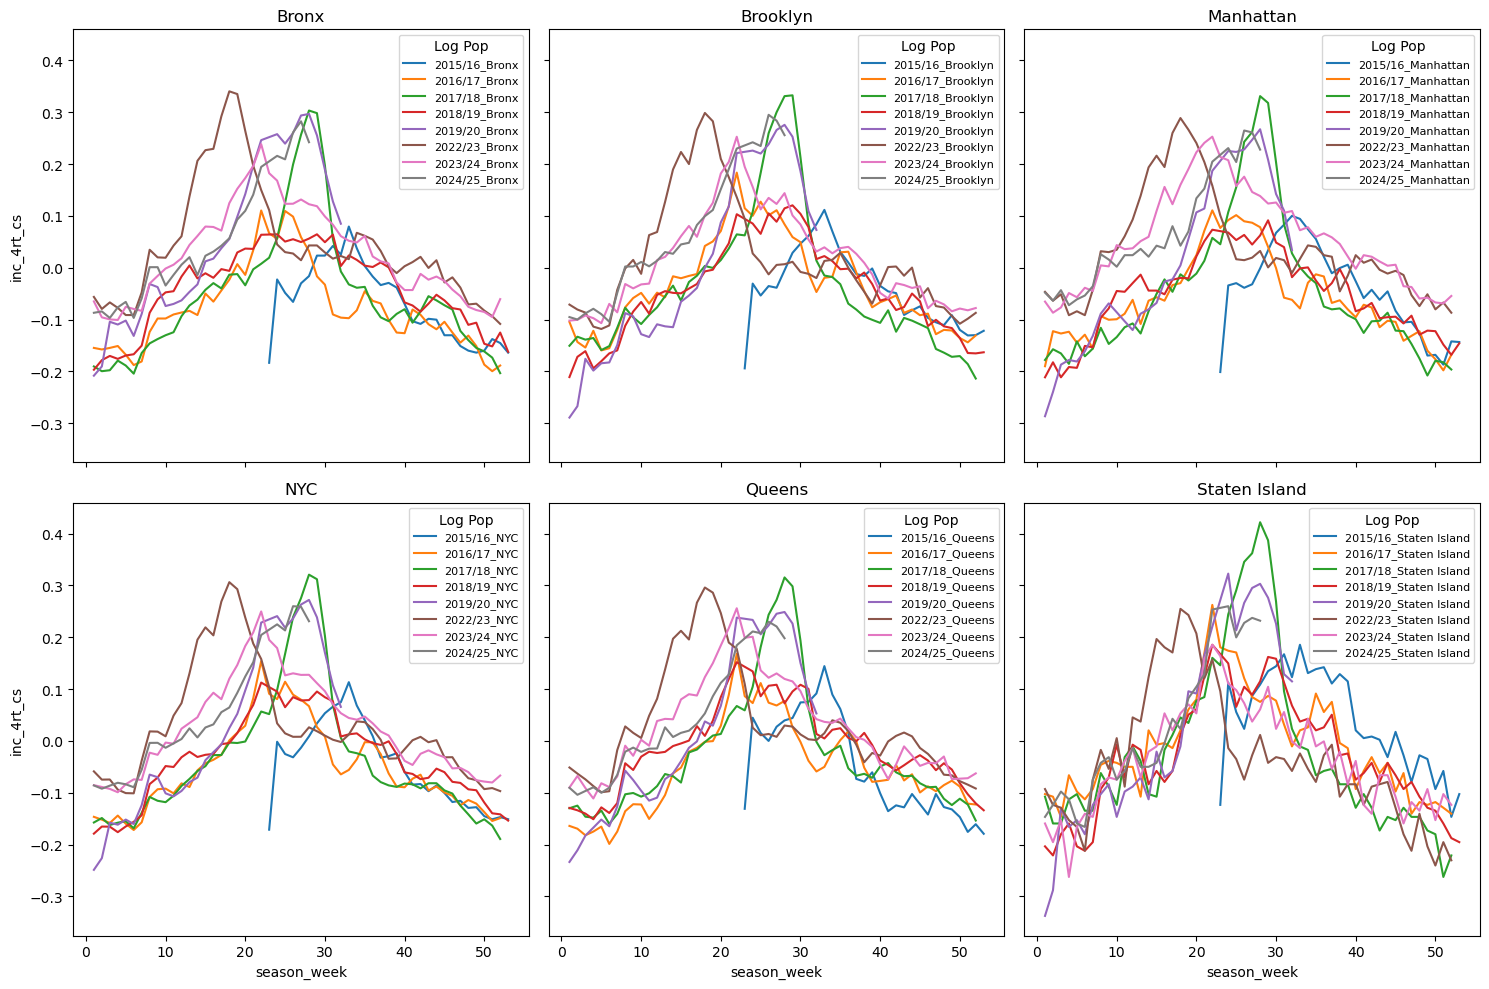

In [55]:
# Filter the DataFrame based on multiple conditions
# Exclude data from the 2020/21 and 2021/22 flu seasons (likely due to COVID-19 disruptions)
# Exclude data between March 1, 2020, and September 1, 2020 (likely due to COVID-19 disruptions)   
filtered_df = df[
    ~df['season'].isin(["2020/21", "2021/22"]) &
    ~((df['wk_end_date'] >= datetime(2020, 3, 1)) & (df['wk_end_date'] <= datetime(2020, 9, 1)))
]
# location 
locations = filtered_df['location'].unique()
nhsn_to_plot = filtered_df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 2D 배열을 1D로 평탄화

# figures by locations
for i, location in enumerate(locations):
    ax = axes[i]  # 각 subplot에 접근
    sns.lineplot(
        data=nhsn_to_plot[nhsn_to_plot['location'] == location],  # 특정 location 데이터만 선택
        x='season_week',
        y='inc_4rt_cs',
        units='season_loc',
        hue='season_loc',  # 색상은 log_pop 기준
        estimator=None,
        ci=None,
        ax=ax
    )
    ax.set_title(location)  # subplot 제목 설정
    ax.legend(title="Log Pop", fontsize=8)  # 범례 설정

# 빈 subplot 숨기기 (location 수가 6보다 적을 경우)
for j in range(len(locations), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [56]:
df = filtered_df

# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [57]:
df

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,...,inc_4rt_cs,inc_4rt_center_factor,location_Bronx,location_Brooklyn,location_Manhattan,location_NYC,location_Queens,location_Staten Island,xmas_week,delta_xmas
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16,14.165639,1.846926,...,-0.183386,0.751979,1,0,0,0,0,0,21.0,2.0
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16,14.788675,1.583215,...,-0.194132,0.755598,0,1,0,0,0,0,21.0,2.0
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16,14.302733,1.507928,...,-0.201181,0.756039,0,0,1,0,0,0,21.0,2.0
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16,15.957481,1.719713,...,-0.171147,0.758169,0,0,0,1,0,0,21.0,2.0
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16,14.661432,1.862237,...,-0.130872,0.764131,0,0,0,0,1,0,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2025-02-01,Brooklyn,66.129918,2646306,5,2025,28,2024/25,14.788675,2.851779,...,0.255747,0.755598,0,1,0,0,0,0,NaN,NaN
2090,2025-02-01,Manhattan,51.112307,1627788,5,2025,28,2024/25,14.302733,2.673946,...,0.227867,0.756039,0,0,1,0,0,0,NaN,NaN
2091,2025-02-01,NYC,70.500911,8516202,5,2025,28,2024/25,15.957481,2.897771,...,0.230982,0.758169,0,0,0,1,0,0,NaN,NaN
2092,2025-02-01,Queens,64.116759,2330124,5,2025,28,2024/25,14.661432,2.829827,...,0.198159,0.764131,0,0,0,0,1,0,NaN,NaN


In [58]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Bronx',
 'location_Brooklyn',
 'location_Manhattan',
 'location_NYC',
 'location_Queens',
 'location_Staten Island',
 'delta_xmas']

In [59]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     wk_end_date       location        inc      pop  epiweek  year  \
0     2016-01-02          Bronx  11.625859  1419250       53  2015   
1     2016-01-02       Brooklyn   6.272895  2646306       53  2015   
2     2016-01-02      Manhattan   5.160377  1627788       53  2015   
3     2016-01-02            NYC   8.736289  8516202       53  2015   
4     2016-01-02         Queens  12.016528  2330124       53  2015   
...          ...            ...        ...      ...      ...   ...   
2089  2025-02-01       Brooklyn  66.129918  2646306        5  2025   
2090  2025-02-01      Manhattan  51.112307  1627788        5  2025   
2091  2025-02-01            NYC  70.500911  8516202        5  2025   
2092  2025-02-01         Queens  64.116759  2330124        5  2025   
2093  2025-02-01  Staten Island  35.313171   492734        5  2025   

     season_week   season    log_pop   inc_4rt  ...  \
0             23  2015/16  14.165639  1.846926  ...   
1             23  2015/16  14.788675  1.583215  .

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [60]:
df.shape

(2094, 59)

In [61]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [62]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     wk_end_date       location        inc      pop  epiweek  year  \
0     2016-01-02          Bronx  11.625859  1419250       53  2015   
1     2016-01-02       Brooklyn   6.272895  2646306       53  2015   
2     2016-01-02      Manhattan   5.160377  1627788       53  2015   
3     2016-01-02            NYC   8.736289  8516202       53  2015   
4     2016-01-02         Queens  12.016528  2330124       53  2015   
...          ...            ...        ...      ...      ...   ...   
2089  2025-02-01       Brooklyn  66.129918  2646306        5  2025   
2090  2025-02-01      Manhattan  51.112307  1627788        5  2025   
2091  2025-02-01            NYC  70.500911  8516202        5  2025   
2092  2025-02-01         Queens  64.116759  2330124        5  2025   
2093  2025-02-01  Staten Island  35.313171   492734        5  2025   

     season_week   season    log_pop   inc_4rt  ...  \
0             23  2015/16  14.165639  1.846926  ...   
1             23  2015/16  14.788675 

In [63]:
df_with_pred_targets.shape

(10470, 62)

In [64]:
df_with_pred_targets.wk_end_date.max()

Timestamp('2025-02-01 00:00:00')

In [65]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2088,2025-02-01,Bronx,108.719394,1419250,5,2025,28,2024/25,14.165639,3.229139,...,0.255288,0.022109,0.025497,-0.023108,-0.052902,-0.036509,-0.055667,NaN,1,NaN
2089,2025-02-01,Brooklyn,66.129918,2646306,5,2025,28,2024/25,14.788675,2.851779,...,0.281245,0.016060,0.021423,0.019404,-0.066241,-0.013334,-0.051473,NaN,1,NaN
2090,2025-02-01,Manhattan,51.112307,1627788,5,2025,28,2024/25,14.302733,2.673946,...,0.256087,0.014683,0.022377,0.033086,-0.035838,0.004989,-0.044370,NaN,1,NaN
2091,2025-02-01,NYC,70.500911,8516202,5,2025,28,2024/25,15.957481,2.897771,...,0.255895,0.014367,0.022502,0.052892,-0.031866,0.036148,-0.049054,NaN,1,NaN
2092,2025-02-01,Queens,64.116759,2330124,5,2025,28,2024/25,14.661432,2.829827,...,0.237888,0.009146,0.022779,0.093458,-0.049911,0.063272,-0.042874,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2025-02-01,Brooklyn,66.129918,2646306,5,2025,28,2024/25,14.788675,2.851779,...,0.281245,0.016060,0.021423,0.019404,-0.066241,-0.013334,-0.051473,NaN,5,NaN
2090,2025-02-01,Manhattan,51.112307,1627788,5,2025,28,2024/25,14.302733,2.673946,...,0.256087,0.014683,0.022377,0.033086,-0.035838,0.004989,-0.044370,NaN,5,NaN
2091,2025-02-01,NYC,70.500911,8516202,5,2025,28,2024/25,15.957481,2.897771,...,0.255895,0.014367,0.022502,0.052892,-0.031866,0.036148,-0.049054,NaN,5,NaN
2092,2025-02-01,Queens,64.116759,2330124,5,2025,28,2024/25,14.661432,2.829827,...,0.237888,0.009146,0.022779,0.093458,-0.049911,0.063272,-0.042874,NaN,5,NaN


In [66]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [67]:
df_with_pred_targets2.shape

(8310, 62)

In [68]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [69]:
#df_with_pred_targets = df_with_pred_targets2
df_with_pred_targets = df_with_pred_targets2.drop(columns=['epiweek'])
    

# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()

x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [70]:
df_test

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2088,2025-02-01,Bronx,108.719394,1419250,2025,28,2024/25,14.165639,3.229139,3.238239,...,0.255288,0.022109,0.025497,-0.023108,-0.052902,-0.036509,-0.055667,NaN,1,NaN
2089,2025-02-01,Brooklyn,66.129918,2646306,2025,28,2024/25,14.788675,2.851779,2.809788,...,0.281245,0.016060,0.021423,0.019404,-0.066241,-0.013334,-0.051473,NaN,1,NaN
2090,2025-02-01,Manhattan,51.112307,1627788,2025,28,2024/25,14.302733,2.673946,2.707683,...,0.256087,0.014683,0.022377,0.033086,-0.035838,0.004989,-0.044370,NaN,1,NaN
2091,2025-02-01,NYC,70.500911,8516202,2025,28,2024/25,15.957481,2.897771,2.919554,...,0.255895,0.014367,0.022502,0.052892,-0.031866,0.036148,-0.049054,NaN,1,NaN
2092,2025-02-01,Queens,64.116759,2330124,2025,28,2024/25,14.661432,2.829827,2.930722,...,0.237888,0.009146,0.022779,0.093458,-0.049911,0.063272,-0.042874,NaN,1,NaN
2093,2025-02-01,Staten Island,35.313171,492734,2025,28,2024/25,13.107725,2.437895,2.504432,...,0.242762,-0.006427,0.014388,0.116724,-0.046072,0.084808,-0.038969,NaN,1,NaN
2088,2025-02-01,Bronx,108.719394,1419250,2025,28,2024/25,14.165639,3.229139,3.238239,...,0.255288,0.022109,0.025497,-0.023108,-0.052902,-0.036509,-0.055667,NaN,2,NaN
2089,2025-02-01,Brooklyn,66.129918,2646306,2025,28,2024/25,14.788675,2.851779,2.809788,...,0.281245,0.016060,0.021423,0.019404,-0.066241,-0.013334,-0.051473,NaN,2,NaN
2090,2025-02-01,Manhattan,51.112307,1627788,2025,28,2024/25,14.302733,2.673946,2.707683,...,0.256087,0.014683,0.022377,0.033086,-0.035838,0.004989,-0.044370,NaN,2,NaN
2091,2025-02-01,NYC,70.500911,8516202,2025,28,2024/25,15.957481,2.897771,2.919554,...,0.255895,0.014367,0.022502,0.052892,-0.031866,0.036148,-0.049054,NaN,2,NaN


In [71]:
import warnings


# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

# Convert season_week and delta_xmas to numeric
x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

#print(x_train.dtypes[x_train.dtypes == 'object'])
#print(x_test.dtypes[x_test.dtypes == 'object'])
# Initialize a DataFrame to store feature importances
feature_importance_df = pd.DataFrame(0, index=x_train.columns, columns=range(num_bags * len(q_levels)))

# Suppress specific warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
        # fit to bag
        model = lgb.LGBMRegressor(verbosity=-1,
                                    # hist_pool_size=1000,
                                    # objective='mean_absolute_error')
                                    objective='quantile',
                                    alpha = q_level,
                                    random_state=lgb_seeds[b, q_ind])
        model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
        
        # oob predictions and test set predictions
        #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
        test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

        # Save feature importances
        col_idx = b * len(q_levels) + q_ind
        feature_importance_df.iloc[:, col_idx] = model.feature_importances_


# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/417496418.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/417496418.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_13138/417496418.py:24: SettingWithCopyW

bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [72]:
feature_importance_df['average_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='average_importance', ascending=False)
feature_importance_df

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,average_importance
horizon,246,292,328,309,339,306,317,294,210,260,...,236,289,335,311,321,307,301,275,206,294.677778
season_week,165,168,195,198,168,207,182,141,155,167,...,187,200,201,210,212,211,201,181,150,183.547778
inc_4rt_cs,155,94,93,65,98,86,112,131,183,165,...,131,72,75,94,93,85,103,131,171,108.953333
inc_4rt_cs_rollmean_w2,92,98,94,94,97,108,89,75,121,90,...,98,115,107,99,90,114,104,85,85,98.234444
inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,70,111,102,140,118,130,118,134,126,60,...,54,77,74,84,97,91,114,118,78,92.361111
inc_4rt_cs_rollmean_w4_lag2,79,89,66,119,102,113,85,67,52,96,...,95,96,89,113,114,125,100,93,65,92.306667
delta_xmas,39,39,38,47,51,35,43,46,34,87,...,43,40,43,64,65,48,61,46,49,92.220000
inc_4rt_cs_rollmean_w4,88,82,98,75,82,95,80,83,64,62,...,96,102,138,91,123,97,90,95,59,91.951111
inc_4rt_cs_taylor_d2_c1_w4t_sNone,122,77,79,76,92,80,93,90,99,101,...,107,93,93,79,93,86,101,85,109,87.382222
inc_4rt_cs_taylor_d1_c1_w5t_sNone,103,99,99,98,81,81,98,79,110,76,...,87,116,73,91,63,59,80,87,91,87.163333


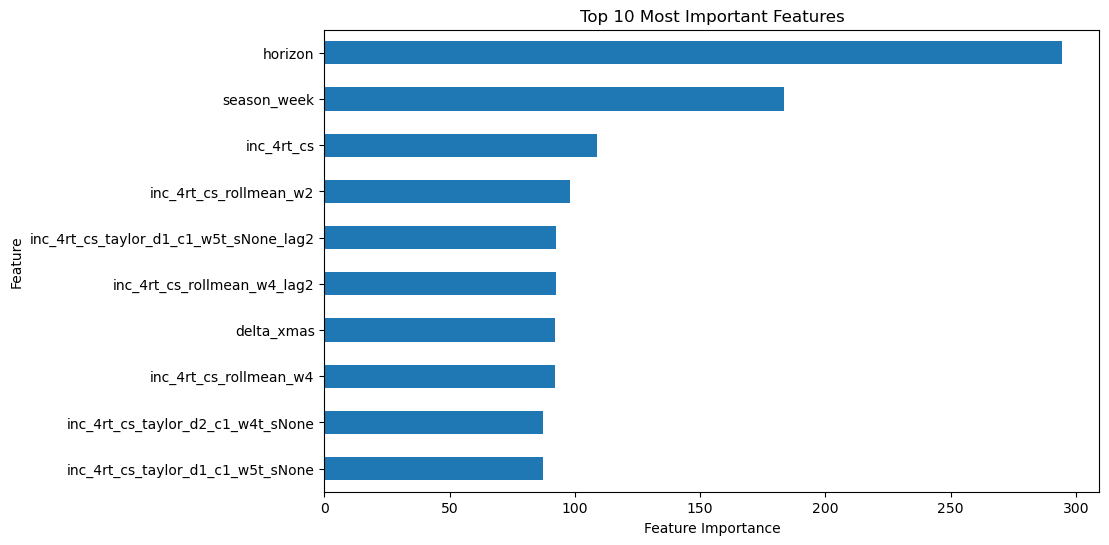

In [73]:
feature_importance_df['average_importance'].head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [74]:
#oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
test_pred_qs_sorted.shape

test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,-0.125689,-0.079882,-0.057675,-0.041158,-0.040348,-0.039848,-0.037973,-0.024423,0.028484
1,-0.127062,-0.083488,-0.062749,-0.052412,-0.046826,-0.045968,-0.044405,-0.029337,0.020234
2,-0.110469,-0.074612,-0.054875,-0.044101,-0.042742,-0.040784,-0.039770,-0.024885,0.021099
3,-0.114866,-0.072042,-0.054355,-0.041580,-0.039873,-0.038880,-0.035075,-0.012234,0.024571
4,-0.101816,-0.062811,-0.048203,-0.035726,-0.031112,-0.025610,-0.009104,-0.001242,0.017255
5,-0.125544,-0.091157,-0.066486,-0.040456,-0.025744,-0.015259,0.001331,0.008426,0.032934
6,-0.135419,-0.098767,-0.092847,-0.091112,-0.085064,-0.083421,-0.063414,-0.026473,0.033958
7,-0.140112,-0.108707,-0.106632,-0.101977,-0.096824,-0.093232,-0.074330,-0.028332,0.024070
8,-0.120802,-0.095254,-0.092704,-0.089424,-0.080650,-0.078274,-0.065121,-0.025385,0.022612
9,-0.122724,-0.092225,-0.089001,-0.088730,-0.080464,-0.077143,-0.048886,-0.013082,0.025678


In [75]:
df_test.reset_index(drop=True, inplace=True)
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,delta_target,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,2025-02-01,Bronx,108.719394,1419250,2025,28,2024/25,14.165639,3.229139,3.238239,...,NaN,-0.125689,-0.079882,-0.057675,-0.041158,-0.040348,-0.039848,-0.037973,-0.024423,0.028484
1,2025-02-01,Brooklyn,66.129918,2646306,2025,28,2024/25,14.788675,2.851779,2.809788,...,NaN,-0.127062,-0.083488,-0.062749,-0.052412,-0.046826,-0.045968,-0.044405,-0.029337,0.020234
2,2025-02-01,Manhattan,51.112307,1627788,2025,28,2024/25,14.302733,2.673946,2.707683,...,NaN,-0.110469,-0.074612,-0.054875,-0.044101,-0.042742,-0.040784,-0.039770,-0.024885,0.021099
3,2025-02-01,NYC,70.500911,8516202,2025,28,2024/25,15.957481,2.897771,2.919554,...,NaN,-0.114866,-0.072042,-0.054355,-0.041580,-0.039873,-0.038880,-0.035075,-0.012234,0.024571
4,2025-02-01,Queens,64.116759,2330124,2025,28,2024/25,14.661432,2.829827,2.930722,...,NaN,-0.101816,-0.062811,-0.048203,-0.035726,-0.031112,-0.025610,-0.009104,-0.001242,0.017255
5,2025-02-01,Staten Island,35.313171,492734,2025,28,2024/25,13.107725,2.437895,2.504432,...,NaN,-0.125544,-0.091157,-0.066486,-0.040456,-0.025744,-0.015259,0.001331,0.008426,0.032934
6,2025-02-01,Bronx,108.719394,1419250,2025,28,2024/25,14.165639,3.229139,3.238239,...,NaN,-0.135419,-0.098767,-0.092847,-0.091112,-0.085064,-0.083421,-0.063414,-0.026473,0.033958
7,2025-02-01,Brooklyn,66.129918,2646306,2025,28,2024/25,14.788675,2.851779,2.809788,...,NaN,-0.140112,-0.108707,-0.106632,-0.101977,-0.096824,-0.093232,-0.074330,-0.028332,0.024070
8,2025-02-01,Manhattan,51.112307,1627788,2025,28,2024/25,14.302733,2.673946,2.707683,...,NaN,-0.120802,-0.095254,-0.092704,-0.089424,-0.080650,-0.078274,-0.065121,-0.025385,0.022612
9,2025-02-01,NYC,70.500911,8516202,2025,28,2024/25,15.957481,2.897771,2.919554,...,NaN,-0.122724,-0.092225,-0.089001,-0.088730,-0.080464,-0.077143,-0.048886,-0.013082,0.025678


In [76]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['wk_end_date' ,'location', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                id_vars=cols_to_keep,
                var_name='quantile',
                value_name = 'delta_hat')
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat
0,2025-02-01,Bronx,1419250,0.242141,1,0.751979,3.238239,0.025,-0.125689
1,2025-02-01,Brooklyn,2646306,0.255747,1,0.755598,2.809788,0.025,-0.127062
2,2025-02-01,Manhattan,1627788,0.227867,1,0.756039,2.707683,0.025,-0.110469
3,2025-02-01,NYC,8516202,0.230982,1,0.758169,2.919554,0.025,-0.114866
4,2025-02-01,Queens,2330124,0.198159,1,0.764131,2.930722,0.025,-0.101816
...,...,...,...,...,...,...,...,...,...
265,2025-02-01,Brooklyn,2646306,0.255747,5,0.755598,2.809788,0.975,0.033980
266,2025-02-01,Manhattan,1627788,0.227867,5,0.756039,2.707683,0.975,0.031339
267,2025-02-01,NYC,8516202,0.230982,5,0.758169,2.919554,0.975,0.032631
268,2025-02-01,Queens,2330124,0.198159,5,0.764131,2.930722,0.975,0.029264


In [77]:
# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat,inc_4rt_cs_target_hat,inc_4rt_target_hat,value
0,2025-02-01,Bronx,1419250,0.242141,1,0.751979,3.238239,0.025,-0.125689,0.116452,2.820871,898.511030
1,2025-02-01,Brooklyn,2646306,0.255747,1,0.755598,2.809788,0.025,-0.127062,0.128685,2.493493,1022.728015
2,2025-02-01,Manhattan,1627788,0.227867,1,0.756039,2.707683,0.025,-0.110469,0.117398,2.373726,516.634745
3,2025-02-01,NYC,8516202,0.230982,1,0.758169,2.919554,0.025,-0.114866,0.116116,2.561266,3664.071755
4,2025-02-01,Queens,2330124,0.198159,1,0.764131,2.930722,0.025,-0.101816,0.096343,2.530413,955.078284
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2025-02-01,Brooklyn,2646306,0.255747,5,0.755598,2.809788,0.975,0.033980,0.289727,2.947597,1997.353687
266,2025-02-01,Manhattan,1627788,0.227867,5,0.756039,2.707683,0.975,0.031339,0.259206,2.759115,943.196544
267,2025-02-01,NYC,8516202,0.230982,5,0.758169,2.919554,0.975,0.032631,0.263613,2.993366,6836.458738
268,2025-02-01,Queens,2330124,0.198159,5,0.764131,2.930722,0.975,0.029264,0.227423,2.915885,1684.225839


In [78]:
# keep just required columns and rename to match hub format
preds_df = preds_df[['wk_end_date', 'location', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['target'] = 'ILI ED visits'
preds_df['horizon'] = preds_df['horizon'] - 1

preds_df['output_type'] = 'quantile'
preds_df



,wk_end_date,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,2025-02-01,Bronx,0,0.025,898.511030,2025-02-08,2025-02-08,ILI ED visits,quantile
1,2025-02-01,Brooklyn,0,0.025,1022.728015,2025-02-08,2025-02-08,ILI ED visits,quantile
2,2025-02-01,Manhattan,0,0.025,516.634745,2025-02-08,2025-02-08,ILI ED visits,quantile
3,2025-02-01,NYC,0,0.025,3664.071755,2025-02-08,2025-02-08,ILI ED visits,quantile
4,2025-02-01,Queens,0,0.025,955.078284,2025-02-08,2025-02-08,ILI ED visits,quantile
...,...,...,...,...,...,...,...,...,...
265,2025-02-01,Brooklyn,4,0.975,1997.353687,2025-03-08,2025-02-08,ILI ED visits,quantile
266,2025-02-01,Manhattan,4,0.975,943.196544,2025-03-08,2025-02-08,ILI ED visits,quantile
267,2025-02-01,NYC,4,0.975,6836.458738,2025-03-08,2025-02-08,ILI ED visits,quantile
268,2025-02-01,Queens,4,0.975,1684.225839,2025-03-08,2025-02-08,ILI ED visits,quantile


In [79]:
preds_df = preds_df[['reference_date', 'location', 'horizon', 'target', 'target_end_date', 'output_type', 'output_type_id', 'value']]
preds_df

,reference_date,location,horizon,target,target_end_date,output_type,output_type_id,value
0,2025-02-08,Bronx,0,ILI ED visits,2025-02-08,quantile,0.025,898.511030
1,2025-02-08,Brooklyn,0,ILI ED visits,2025-02-08,quantile,0.025,1022.728015
2,2025-02-08,Manhattan,0,ILI ED visits,2025-02-08,quantile,0.025,516.634745
3,2025-02-08,NYC,0,ILI ED visits,2025-02-08,quantile,0.025,3664.071755
4,2025-02-08,Queens,0,ILI ED visits,2025-02-08,quantile,0.025,955.078284
...,...,...,...,...,...,...,...,...
265,2025-02-08,Brooklyn,4,ILI ED visits,2025-03-08,quantile,0.975,1997.353687
266,2025-02-08,Manhattan,4,ILI ED visits,2025-03-08,quantile,0.975,943.196544
267,2025-02-08,NYC,4,ILI ED visits,2025-03-08,quantile,0.975,6836.458738
268,2025-02-08,Queens,4,ILI ED visits,2025-03-08,quantile,0.975,1684.225839


In [80]:
if not Path('epiENGAGE-GBQR/model_output/NYC_ED').exists():
    Path('epiENGAGE-GBQR/model_output/NYC_ED').mkdir(parents=True)

preds_df.to_csv(f'epiENGAGE-GBQR/model_output/NYC_ED/{str(ref_date)}-epiENGAGE-GBQR.csv', index=False)
